凸性（convexity）在优化算法的设计中起到至关重要的作用，这主要是由于在这种情况下对算法进行分析和测试要容易。\
如果算法在凸性条件设定下的效果很差，那通常我们很难在其他条件下看到好的结果。\
此外，即使深度学习中的优化问题通常是非凸的，它们也经常在局部极小值附近表现出一些凸性。\
这可能会产生一些像 (Izmailov et al., 2018)这样比较有意思的新优化变体。

In [1]:
%matplotlib inline
import numpy as np
import torch
from D2L import d2l

## 1 定义

### 凸集

凸集（convex set）是凸性的基础。\
简单地说，如果对于 $\forall a, b ∈ \mathcal{X}$，连接a和b的线段也位于 $\mathcal{X}$ 中，则向量空间中的一个集合 $\mathcal{X}$ 是凸（convex）的。\
在数学术语上，这意味着对于 $\forall λ ∈ [0, 1]$，我们得到
$$
λa+(1-λ)b\in \mathcal{X},\quad a,b\in\mathcal{X}\tag{11.2.1}
$$\
图11.2.1里，第一组存在不包含在集合内部的线段，所以该集合是非凸的，而另外两组则没有这样的问题。

<img src="./img/11.2.1.png">

接下来来看一下交集 图11.2.2。\
假设 $\mathcal{X,Y}$ 是凸集，那么 $\mathcal{X∩Y}$ 也是凸集的。\
现在考虑 $\forall a, b ∈ \mathcal{X∩Y}$，所以连接a和b的线段包含在 $\mathcal{X,Y}$中。\
鉴于此，它们也需要包含在 $\mathcal{X∩Y}$ 中，从而证明我们的定理。

<img src="./img/11.2.2.png">

给定凸集 $\mathcal{X_i}$，它们的交集 $∩_i\mathcal{X}_i$ 是凸的。\
但是反向是不正确的，考虑两个不相交的集合 $\mathcal{X∩Y} = ∅$，取 $a ∈ \mathcal{X}$ 和 $b ∈ \mathcal{Y}$。\
因为$\mathcal{X∩Y} = ∅$，在 图11.2.3中连接a和b的线段需要包含一部分既不在X 也不在Y中。\
因此线段也不在X ∪ Y中，因此证明了凸集的并集不一定是凸的，即非凸（nonconvex）的。

<img src="./img/11.2.3.png">

通常，深度学习中的问题是在凸集上定义的。\
例如，$\mathbb{R}^d$。\
在某些情况下，我们使用有界长度的变量，例如球的半径定义为 $\{x|x ∈ \mathbb{R}^d,∥x∥ ≤ r\}$。

### 凸函数

给定一个凸集X ，如果对于 $\forall x, x′ ∈ X$ 和所有 $λ ∈ [0, 1]$，函数 $f : X → R$ 是凸的，我们可以得到
$$
λf(x) + (1 − λ)f (x') ≥ f (λx + (1 − λ)x').\tag{11.2.2}
$$

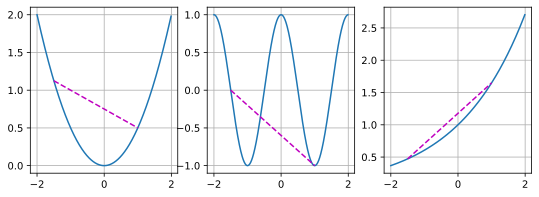

In [3]:
f = lambda x: 0.5 * x**2 # 凸函数
g = lambda x: torch.cos(np.pi * x) # 非凸函数
h = lambda x: torch.exp(0.5 * x) # 凸函数
x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)
d2l.plt.show()

### 琴生不等式

凸性定义的一种推广：
$$
\sum_i α_if (x_i) ≥ f(\sum_i α_ix_i),\quad E_X [f (X)] ≥ f (E_X [X])\tag{11.2.3}
$$
其中 $α_i$ 是满足 $\sum_i α_i=1$ 的非负实数，X是随机变量。\
凸函数的期望不小于期望的凸函数，其中后者通常是一个更简单的表达式。\
为了证明第一个不等式，我们多次将凸性的定义应用于一次求和中的一项。

詹森不等式的一个常见应用：\
用一个较简单的表达式约束一个较复杂的表达式。\
例如，它可以应用于部分观察到的随机变量的对数似然。\
由于 $∫ P (Y )P (X | Y )dY = P (X)$，所以
$$
E_{Y ∼P (Y )}[− \log P (X | Y )] ≥ − \log P (X),\tag{11.2.4}
$$
Y 是典型的未观察到的随机变量，P (Y ) 是它可能如何分布的最佳猜测，P (X)是将 Y 积分后的分布。\
例如，在聚类中 Y 可能是簇标签，而在应用簇标签时，P (X | Y )是生成模型。

## 2 性质

### 局部极小值是全局极小值

用反证法给出证明。\
假设 $x^∗ ∈ \mathcal{X}$ 是一个局部最小值，则存在一个很小的正值 $\delta$，使得当 $x ∈ \mathcal{X}$ 满足 $0 < |x−x^∗| ≤ \delta$ 时，有 $f (x^∗) < f (x)$。\
现在假设局部极小值 $x^∗$ 不是 f 的全局极小值：$\exists x' ∈ \mathcal{X}$ 使得 $f (x') < f (x^∗)$。\
则 $\exists λ ∈ [0, 1)$，比如 $λ =1 − \frac{p}{|x^∗ −x'|}$ ，使得 $0 < |λx^∗ + (1 − λ)x' − x^∗| ≤ \delta$。\
然而，根据凸性的性质，有
$$
\begin{align}
f (λx^∗ + (1 − λ)x') &≤ λf (x^∗) + (1 − λ)f (x') \\
&< λf (x^∗) + (1 − λ)f (x^∗) \\
&= f (x^∗)
\end{align}\tag{11.2.5}
$$

这与 $x^∗$ 是局部最小值相矛盾。因此，$\not\exists x' ∈ X$ 满足 $f (x') < f (x^∗)$。\
综上所述，局部最小值 $x^∗$ 也是全局最小值。

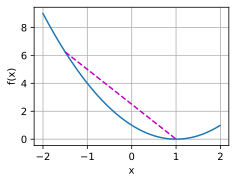

In [4]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')

这意味着如果我们最小化函数，我们就不会“卡住”。\
但是这并不意味着不能有多个全局最小值，或者可能不存在一个全局最小值。\
例如，函数 $f (x) = \max(|x| − 1, 0)$ 在 $[−1, 1]$ 区间上都是最小值。\
相反，函数 $f (x) = \exp(x)$ 在 $\mathbb{R}$ 上没有取得最小值。对于 $x → −∞$，它趋近于0，但是没有 $f (x) = 0$ 的x。

### 凸函数的下水平集是凸的

通过凸函数的下水平集（below sets）定义凸集。\
具体来说，给定一个定义在凸集 $\mathcal{X}$ 上的凸函数f ，其任意一个下水平集
$$
\mathcal{S}_b:=\{x|x\in\mathcal{X},f(x)\leq b\}\tag{11.2.6}
$$
是凸的。\
Pf: $\forall x, x' ∈ \mathcal{S}_b$，我们需要证明：当 $λ ∈ [0, 1]$ 时，$λx + (1 − λ)x' ∈ \mathcal{S}_b$。因为 $f (x) ≤b$ 且 $f (x') ≤ b$，所以
$$
f (λx + (1 − λ)x') ≤ λf (x) + (1 − λ)f (x') ≤ b.\tag{11.2.7}
$$

### 凸性和二阶导数

当一个函数的二阶导数 $f :\mathbb{R}^n → \mathbb{R}$ 存在时，我们很容易检查这个函数的凸性。\
我们需要做的就是检查 $∇^2f ⪰ 0$，即 $\forall \mathbf{x} ∈ \mathbb{R}^n，\mathbf{x}^⊤\mathbf{Hx} ≥ 0$. 例如，函数 $f(\mathbf{x}) = \frac{1}{2} ∥\mathbf{x}∥^2$ 是凸的，因为 $∇^2f = 1$，即其导数是单位矩阵。\
更正式地讲，f 为凸函数 $\Longleftrightarrow$ 任意二次可微一维函数 $f:\mathbb{R}^n → \mathbb{R}$ 是凸的。\
对于任意二次可微多维函数$f :\mathbb{R}^n → \mathbb{R}$，它是凸的 $\leftrightarrow$ 它的Hessian$∇^2f ⪰ 0$。

首先，我们来证明一下一维情况。为了证明凸函数的 $f''(x) ≥ 0$，我们使用：
$$
\frac{1}{2} f (x + ε) + \frac{1}{2} f (x − ε) ≥ f( \frac{x + ε}{2} + \frac{x- ε}{2})= f (x).\tag{11.2.8}
$$
因为二阶导数是由有限差分的极限给出的，所以遵循
$$
f''(x) = \lim_{ε→0} \frac{f (x + ε) + f (x − ε) − 2f (x)}{ε^2} ≥ 0.\tag{11.2.9}
$$
为了证明 $f''≥ 0$ 可以推导f 是凸的，我们使用这样一个事实：$f''≥ 0$ 意味着 $f'$ 非递减。\
假设 $a < x < b$ 是 $\mathbb{R}$ 中的三个点，其中，$x = (1 − λ)a + λb$ 且 $λ ∈ (0, 1)$. 根据中值定理，$\exists α ∈ [a, x]，β ∈ [x, b]$，使得
$$
f'(α) = \frac{f (x) − f (a)}{x − a},\quad f'(β) = \frac{f (b) − f (x)}{b − x}\tag{11.2.10}
$$
通过单调性 $f'(β) ≥ f'(α)$，因此
$$
\frac{x − a}{b − a} f (b) + \frac{b − x}{b − a} f (a) ≥ f (x).\tag{11.2.11}
$$
由于 $x = (1 − λ)a + λb$，所以
$$
λf (b) + (1 − λ)f (a) ≥ f ((1 − λ)a + λb),\tag{11.2.12}
$$
从而证明了凸性。

第二，我们需要一个引理证明多维情况：$f : \mathbb{R}^n → \mathbb{R}$ 是凸的 $\Longleftrightarrow\forall x, y ∈ \mathbb{R}^n$
$$
g(z)\stackrel{\text{def}}{=}f (z\mathbf{x} + (1 − z)\mathbf{y}), z ∈ [0, 1]\tag{11.2.13}
$$
是凸的。\
为了证明f 的凸性意味着g是凸的，我们可以证明，$\forall a,b,λ ∈ [0,1] (0 ≤ λa + (1 − λ)b ≤ 1)$,
$$
\begin{align}
&g(λa + (1 − λ)b)\\
=&f ((λa + (1 − λ)b) \mathbf{x} + (1 − λa − (1 − λ)b) \mathbf{y})\\
=&f (λ (a\mathbf{x} + (1 − a)\mathbf{y}) + (1 − λ) (b\mathbf{x} + (1 − b)\mathbf{y}))\\
≤&λf (a\mathbf{x} + (1 − a)\mathbf{y}) + (1 − λ)f (b\mathbf{x} + (1 − b)\mathbf{y})\\
=&λg(a) + (1 − λ)g(b).
\end{align}\tag{11.2.14}
$$
为了证明这一点，我们可以证明对 $\forall \lambda\in[0,1]$:
$$
\begin{align}
&f(λ (λ\mathbf{x} + (1 − λ)\mathbf{y})\\
=&g(λ · 1 + (1 − λ) · 0)\\
≤&λg(1) + (1 − λ)g(0)\\
=&λf(\mathbf{x}) + (1 − λ)f(\mathbf{y}).
\end{align}\tag{11.2.15}
$$

最后，利用上面的引理和一维情况的结果，我们可以证明多维情况：多维函数 $f : \mathbb{R}^n → \mathbb{R}$是凸函数 $\Longleftrightarrow g(z)\stackrel{\text{def}}{=}f (z\mathbf{x} + (1 − z)\mathbf{y}), z ∈ [0, 1], \mathbf{x,y} ∈ \mathbb{R}^n$ 是凸的。\
根据一维情况，此条成立的条件为，iff $\forall \mathbf{x,y} ∈ \mathbb{R}^n，g'' = (\mathbf{x-y})^⊤\mathbf{H(x-y)} ≥ 0\ (H \stackrel{\text{def}}{=} ∇^2f)$。\
这相当于根据半正定矩阵的定义，$\mathbf{H}⪰ 0$。

### 11.2.3 约束


凸优化的一个很好的特性是能够让我们有效地处理约束（constraints）。即它使我们能够解决以下形式的约
束优化（constrained optimization）问题：
$$
\begin{align}
\mathop{\text{minimize}}\limits_{\mathbf{x}}f(\mathbf{x}) \\
c_i(\mathbf{x})\leq 0,\quad \forall i\in\{1,...,N\}
\end{align}\tag{11.2.16}
$$
f 是目标函数，ci是约束函数。例如第一个约束c1(x) = ∥x∥2 − 1，则参数x被限制为单位球。如果第二个
约束c2(x) = v⊤x + b，那么这对应于半空间上所有的x。同时满足这两个约束等于选择一个球的切片作为约
束集。

#### 拉格朗日函数

通常，求解一个有约束的优化问题是困难的，解决这个问题的一种方法来自物理中相当简单的直觉。\
想象一个球在一个盒子里，球会滚到最低的地方，重力将与盒子两侧对球施加的力平衡。简而言之，目标函数（即
重力）的梯度将被约束函数的梯度所抵消（由于墙壁的“推回”作用，需要保持在盒子内）。\
请注意，任何不起作用的约束（即球不接触壁）都将无法对球施加任何力。

这里我们简略拉格朗日函数L的推导，上述推理可以通过以下鞍点优化问题来表示：
$$
L(\mathbf{x}, α_1, . . . , α_n) = f(\mathbf{x}) + \sum_{i=1}^nα_ic_i(\mathbf{x}),\quad α_i ≥ 0.\tag{11.2.17}
$$
这里的变量 $α_i(i = 1, . . . , n)$ 是所谓的拉格朗日乘数（Lagrange multipliers），它确保约束被正确地执行。\
选择它们的大小足以确保所有 i 的 $c_i(\mathbf{x}) ≤ 0$。例如，对于 $c_i(\mathbf{x}) < 0$ 中任意 $\mathbf{x}$，我们最终会选择 $α_i = 0$。\
此外，这是一个鞍点（saddlepoint）优化问题。\
在这个问题中，我们想要使L相对于αi最大化（maximize），同时使它相对于x最小化（minimize）。有大量的文献解释如何得出函数L(x, α1, . . . , αn)。我们这里只需要知道L的鞍点是原始约束优化问题的最优解就足够了。

#### 惩罚

一种至少近似地满足约束优化问题的方法是采用拉格朗日函数L。\
除了满足 $c_i(\mathbf{x}) ≤ 0$ 之外，我们只需将 $α_ic_i(\mathbf{x})$ 添加到目标函数$f(x)$。这样可以确保不会严重违反约束。\
事实上，我们一直在使用这个技巧。比如权重衰减 4.5节，在目标函数中加入 $λ^2 |w|^2$，以确保w不会增长太大。\
使用约束优化的观点，我们可以看到，对于若干半径r，这将确保 $|w|^2 − r^2 ≤ 0$。\
通过调整λ的值，我们可以改变w的大小。\
通常，添加惩罚是确保近似满足约束的一种好方法。在实践中，这被证明比精确的满意度更可靠。\
此外，对于非凸问题，许多使精确方法在凸情况下的性质（例如，可求最优解）不再成立。

#### 投影

满足约束条件的另一种策略是投影（projections）。\
同样，我们之前也遇到过，例如在 8.5节中处理梯度截断时，我们通过
$$
\mathbf{g}\leftarrow\mathbf{g}\cdot\min(1, \theta/||\mathbf{g}||),\tag{11.2.18}
$$
确保梯度的长度以 $θ$ 为界限。
这就是 $\mathbf{g}$ 在半径为 $θ$ 的球上的投影（projection）。\
更泛化地说，在凸集 $\mathcal{X}$ 上的投影被定义为
$$
\text{Proj}_{\mathcal{X}} (\mathbf{x}) = \arg\min_{\mathbf{x}'\in\mathcal{X}}||\mathbf{x}-\mathbf{x}'||\tag{11.2.19}
$$
它是 $\mathcal{X}$ 中离 $\mathbf{x}$ 最近的点。
